<a href="https://colab.research.google.com/github/Arvind-55555/Measuring-CO-sequestration-of-a-tree/blob/main/Measuring_CO_sequestration_of_a_tree_Model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import shap
import requests
from datetime import datetime
import os

In [2]:
# 1. Define helper functions
def fetch_noaa_data(location, start_date, end_date, api_token, save_path):
    """Fetch NOAA climate data for a given location and date range, and save it as a CSV"""
    base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {'token': api_token}
    params = {
        'datasetid': 'GHCND',  # Global Historical Climatology Network
        'locationid': location,  # FIPS Location ID. Eg: 'FIPS:12086' Florida, Miami-Dade
        'startdate': start_date,
        'enddate': end_date,
        'datatypeid': ['TAVG', 'PRCP'], # Average Temperature and precipitation data
        'limit':1000,  #Adjust as needed
    }
    response = requests.get(base_url, params=params, headers=headers)
    if response.status_code == 200:
      data = response.json()['results']
      df = pd.DataFrame(data)
      df["date"] = pd.to_datetime(df["date"])
      df.sort_values(by="date", inplace=True)
      df.to_csv(save_path, index=False)
      print(f"Successfully fetched and saved data to {save_path}")
    else:
      print(f"Error fetching data: Status Code {response.status_code}")

In [3]:
def get_processed_climate_data(location, save_path):
    """Load climate data from CSV, handle missing data and return avg temperature and avg precipitation"""
    if not os.path.exists(save_path):
        print("Please Fetch the NOAA data first")
        return None, None
    climate_df = pd.read_csv(save_path, parse_dates=['date'])
    climate_df_avg = climate_df.groupby(climate_df['date'].dt.year).agg(
          AvgTemperature = pd.NamedAgg(column = "value", aggfunc = lambda x : x[climate_df['datatype'] == 'TAVG'].mean()),
           AvgPrecipitation = pd.NamedAgg(column = "value", aggfunc = lambda x: x[climate_df['datatype'] == 'PRCP'].mean()),
          )
    climate_df_avg.reset_index(inplace=True)
    climate_df_avg.rename(columns={'date': 'year'}, inplace = True)
    #Handle missing data by filling average
    climate_df_avg["AvgTemperature"].fillna(climate_df_avg["AvgTemperature"].mean(), inplace = True)
    climate_df_avg["AvgPrecipitation"].fillna(climate_df_avg["AvgPrecipitation"].mean(), inplace = True)
    return climate_df_avg['AvgTemperature'].values, climate_df_avg["AvgPrecipitation"].values

In [4]:
def get_soil_data_from_api(location, seed): #Dummy implementation
  """Placeholder: This function represents how to fetch real soil data"""
  np.random.seed(seed)
  soil_type = np.random.choice(['Clay', 'Loam', 'Sand'])
  if soil_type == 'Clay':
      return np.random.normal(6.0, 0.5), np.random.normal(5, 2), np.random.normal(0.4, 0.2), soil_type
  elif soil_type == 'Loam':
      return np.random.normal(6.5, 0.6), np.random.normal(6, 1), np.random.normal(0.5, 0.1), soil_type
  else :
      return np.random.normal(5.5, 1), np.random.normal(3, 1), np.random.normal(0.2, 0.1), soil_type

In [9]:
# 2. locations

locations = {
    'Miami': 'FIPS:12086',  # Miami-Dade County, Florida
    'Seattle': 'FIPS:53033',  # King County, Washington
    'Denver': 'FIPS:08031',   # Denver County, Colorado
}

In [10]:
# Date Range
start_date = "2000-01-01"
end_date = datetime.now().strftime("%Y-%m-%d") #current date

In [12]:
# 3. Simulate Data with Real-like Characteristics
np.random.seed(42)
n_samples = 1000

# Species-specific parameters based on literature (simplified)
species_params = {
    'Oak': {'max_height': 30, 'max_dbh': 150, 'growth_rate': 0.05, 'base_carbon_seq': 0.18, 'optimal_temp': 18, 'optimal_rainfall': 100, 'optimal_soil_pH': 6.5, 'optimal_nutrient':6, 'optimal_moisture':0.4},
    'Pine': {'max_height': 25, 'max_dbh': 100, 'growth_rate': 0.07, 'base_carbon_seq': 0.10, 'optimal_temp': 15, 'optimal_rainfall': 70, 'optimal_soil_pH': 5.5, 'optimal_nutrient': 4, 'optimal_moisture':0.35},
    'Maple': {'max_height': 20, 'max_dbh': 80, 'growth_rate': 0.04, 'base_carbon_seq': 0.15, 'optimal_temp': 20, 'optimal_rainfall': 90, 'optimal_soil_pH': 6.0, 'optimal_nutrient': 5, 'optimal_moisture':0.5},
    'Birch': {'max_height': 20, 'max_dbh': 60, 'growth_rate': 0.08, 'base_carbon_seq': 0.12, 'optimal_temp': 16, 'optimal_rainfall': 80, 'optimal_soil_pH': 5.0, 'optimal_nutrient': 3, 'optimal_moisture':0.45}
}

In [13]:
# Simulate tree data
species = np.random.choice(list(species_params.keys()), size=n_samples)
age = np.random.randint(1, 50, size=n_samples) #increased age for better diminishing returns
location = np.random.choice(list(locations.keys()), size=n_samples)

soil_pH = np.zeros(n_samples)
soil_nutrient = np.zeros(n_samples)
soil_moisture = np.zeros(n_samples)
soil_type = [None]*n_samples

for i in range(n_samples):
  soil_pH[i], soil_nutrient[i], soil_moisture[i], soil_type[i] = get_soil_data_from_api(location[i], i)

In [15]:
# Calculate tree dimensions based on Allometric equation (simplified) and Literature
def calculate_dimensions(species, age, max_height, max_dbh):
   # Allometric Equation (Simplified Version)
    dbh = max_dbh*(1 - np.exp(-species_params[species]['growth_rate']* age))
    height = max_height*(1 - np.exp(-species_params[species]['growth_rate']* age))
    return dbh, height

In [16]:
dbh = np.zeros(n_samples)
height = np.zeros(n_samples)

for i in range(n_samples):
  dbh[i], height[i] = calculate_dimensions(species[i], age[i], species_params[species[i]]['max_height'], species_params[species[i]]['max_dbh'])

In [17]:
# Complex Soil effect based on species and soil properties
def calculate_soil_effect(species, soil_pH, soil_nutrient, soil_moisture):
  species_p = species_params[species]
  pH_effect = np.exp(-((soil_pH - species_p['optimal_soil_pH'])**2) / (2 * 1**2))
  nutrient_effect =  np.exp(-((soil_nutrient - species_p['optimal_nutrient'])**2) / (2 * 2**2))
  moisture_effect = np.exp(-((soil_moisture - species_p['optimal_moisture'])**2) / (2* 0.1**2))
  soil_effect = pH_effect * nutrient_effect * moisture_effect
  return soil_effect

In [18]:
# Calculate CO2 sequestration with nuanced environmental and soil impact
annual_co2_seq = np.zeros(n_samples)
for i in range(n_samples):
    species_p = species_params[species[i]]
    base_carbon_seq = species_p['base_carbon_seq']
    temp_effect = np.exp(-((temperature[i] - species_p['optimal_temp']) ** 2) / (2 * 5**2))
    rainfall_effect = np.exp(-((rainfall[i] - species_p['optimal_rainfall']) ** 2) / (2 * 30**2))
    soil_effect = calculate_soil_effect(species[i], soil_pH[i], soil_nutrient[i], soil_moisture[i])
    annual_co2_seq[i] = base_carbon_seq * (dbh[i]*height[i] ) * temp_effect * rainfall_effect * soil_effect

In [19]:
df = pd.DataFrame({'species': species,
                   'age': age,
                   'location': location,
                   'temperature': temperature,
                   'rainfall': rainfall,
                   'soil_pH': soil_pH,
                   'soil_nutrient': soil_nutrient,
                   'soil_moisture': soil_moisture,
                   'dbh': dbh,
                   'height': height,
                   'soil_type': soil_type,
                   'annual_co2_seq': annual_co2_seq})

In [20]:
df.head(10)

,species,age,location,temperature,rainfall,soil_pH,soil_nutrient,soil_moisture,dbh,height,soil_type,annual_co2_seq
0,Maple,17,Denver,0.0,0.0,6.561397,5.605610,0.414172,39.470641,9.867660,Clay,1.229107e-04
1,Birch,9,Denver,0.0,0.0,6.170152,4.597127,0.658275,30.794865,10.264955,Loam,2.713383e-04
2,Oak,33,Seattle,0.0,0.0,5.988718,6.324896,0.222502,121.192514,24.238503,Clay,5.618882e-04
3,Maple,20,Denver,0.0,0.0,5.684128,1.994045,0.165802,44.053683,11.013421,Sand,3.132166e-07
4,Maple,13,Miami,0.0,0.0,5.818870,4.039999,0.094852,32.438356,8.109589,Sand,3.515182e-08
5,Birch,28,Denver,0.0,0.0,5.206040,3.371591,0.197670,53.612490,17.870830,Sand,7.826035e-04
6,Oak,48,Miami,0.0,0.0,5.323916,2.409290,0.265880,136.392307,27.278461,Sand,1.614412e-04
7,Oak,29,Seattle,0.0,0.0,5.839698,7.914166,0.418633,114.814457,22.962891,Clay,1.406684e-03
8,Maple,13,Miami,0.0,0.0,5.217970,5.361132,0.393565,32.438356,8.109589,Clay,6.047774e-05
9,Pine,46,Denver,0.0,0.0,5.485339,0.715028,0.187160,96.004494,24.001124,Sand,1.159535e-02


In [21]:
# 4. Data Preprocessing
X = df.drop('annual_co2_seq', axis=1)
y = df['annual_co2_seq']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['age', 'temperature', 'rainfall', 'soil_pH', 'soil_nutrient', 'soil_moisture', 'dbh', 'height']
categorical_features = ['species', 'location', 'soil_type']

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [23]:
# 5. Model Training with Hyperparameter Tuning (Randomized Search)
def randomized_search(model, param_dist, X, y, cv=5, n_iter=10):
    random_search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42)
    random_search.fit(X, y)
    best_model = random_search.best_estimator_
    best_score = np.sqrt(-random_search.best_score_)
    return best_model, best_score

In [25]:
# Define hyperparameter distributions to sample from
rf_params = {
    'n_estimators': st.randint(50, 200),
    'max_depth': [3, 5, 10, None],
    'min_samples_split': st.randint(2, 10),
    'min_samples_leaf': st.randint(1, 5)
}

In [26]:
gbr_params = {
    'n_estimators': st.randint(50, 200),
    'learning_rate': st.uniform(0.01, 0.2),
    'max_depth': [3, 5, 8],
    'min_samples_split': st.randint(2, 10),
    'min_samples_leaf': st.randint(1, 5)
}


In [27]:
#Random search CV to find best models
print("Tuning Random Forest Model")
best_rf, best_rf_rmse = randomized_search(RandomForestRegressor(random_state=42), rf_params, X_train_processed, y_train)
print(f"Random Forest Tuned RMSE: {best_rf_rmse:.2f}")
print(f"Best Random Forest params: {best_rf}")

print("\nTuning Gradient Boosting Model")
best_gbr, best_gbr_rmse = randomized_search(GradientBoostingRegressor(random_state=42), gbr_params, X_train_processed, y_train)
print(f"Gradient Boosting Tuned RMSE: {best_gbr_rmse:.2f}")
print(f"Best Gradient Boosting params: {best_gbr}")

Tuning Random Forest Model
Random Forest Tuned RMSE: 0.01
Best Random Forest params: RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=124, random_state=42)

Tuning Gradient Boosting Model
Gradient Boosting Tuned RMSE: 0.01
Best Gradient Boosting params: GradientBoostingRegressor(learning_rate=0.08997219434305109, max_depth=8,
                          min_samples_leaf=2, min_samples_split=7,
                          random_state=42)


In [28]:
# 6. Model Evaluation
def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"Cross-validation RMSE scores: {rmse_scores}")
    print(f"Average RMSE: {rmse_scores.mean():.2f}")
    return rmse_scores

In [29]:
print("\nRandom Forest Performance After Tuning:")
rf_rmse_scores = evaluate_model(best_rf, X_train_processed, y_train)
best_rf.fit(X_train_processed, y_train)
rf_y_pred = best_rf.predict(X_test_processed)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f"Random Forest Test R-squared: {rf_r2:.2f}")

print("\nGradient Boosting Performance After Tuning:")
gbr_rmse_scores = evaluate_model(best_gbr, X_train_processed, y_train)
best_gbr.fit(X_train_processed, y_train)
gbr_y_pred = best_gbr.predict(X_test_processed)
gbr_r2 = r2_score(y_test, gbr_y_pred)
print(f"Gradient Boosting Test R-squared: {gbr_r2:.2f}")


Random Forest Performance After Tuning:
Cross-validation RMSE scores: [0.00604057 0.00612341 0.00749021 0.0044498  0.00525828]
Average RMSE: 0.01
Random Forest Test R-squared: 0.82

Gradient Boosting Performance After Tuning:
Cross-validation RMSE scores: [0.0052454  0.00632936 0.00744396 0.00493648 0.00417741]
Average RMSE: 0.01
Gradient Boosting Test R-squared: 0.82


In [30]:
# 7. Ensemble Model
ensemble_model = VotingRegressor(estimators=[('rf', best_rf), ('gbr', best_gbr)])
ensemble_model.fit(X_train_processed, y_train)
ensemble_y_pred = ensemble_model.predict(X_test_processed)
ensemble_r2 = r2_score(y_test, ensemble_y_pred)
print(f"\nEnsemble Model R-squared: {ensemble_r2:.2f}")
ensemble_rmse_scores = evaluate_model(ensemble_model, X_train_processed, y_train)


Ensemble Model R-squared: 0.83
Cross-validation RMSE scores: [0.00549616 0.00602409 0.00729295 0.00455101 0.00461699]
Average RMSE: 0.01


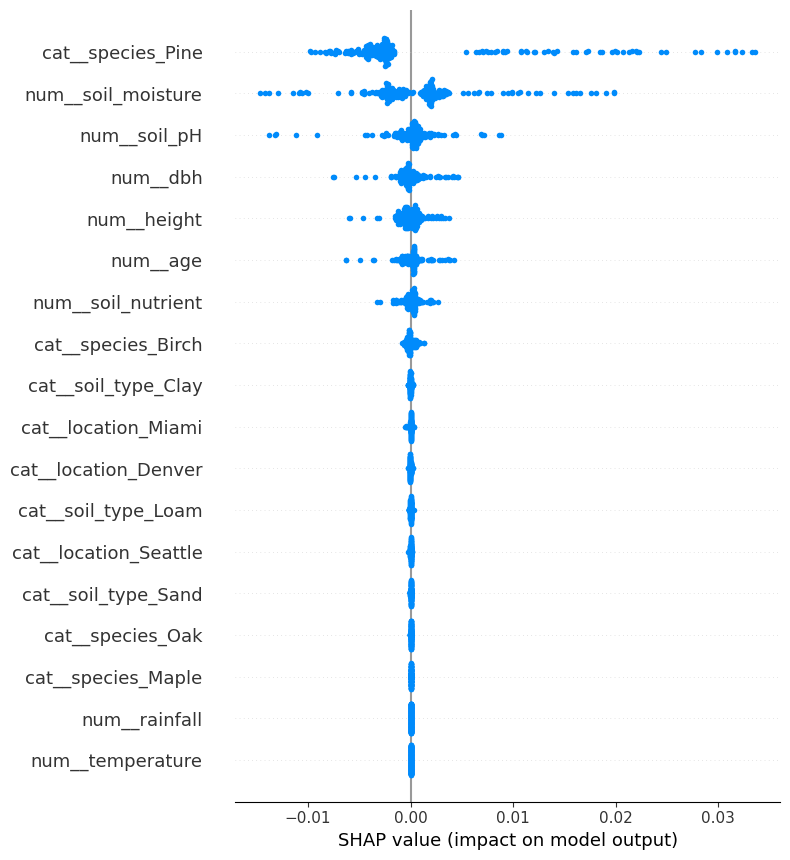

In [31]:
# 8. Model Interpretation with SHAP
explainer = shap.TreeExplainer(best_rf) #can use best_gbr as well
shap_values = explainer.shap_values(X_test_processed)
#summarize the effects of all the features
shap.summary_plot(shap_values, features=preprocessor.get_feature_names_out())

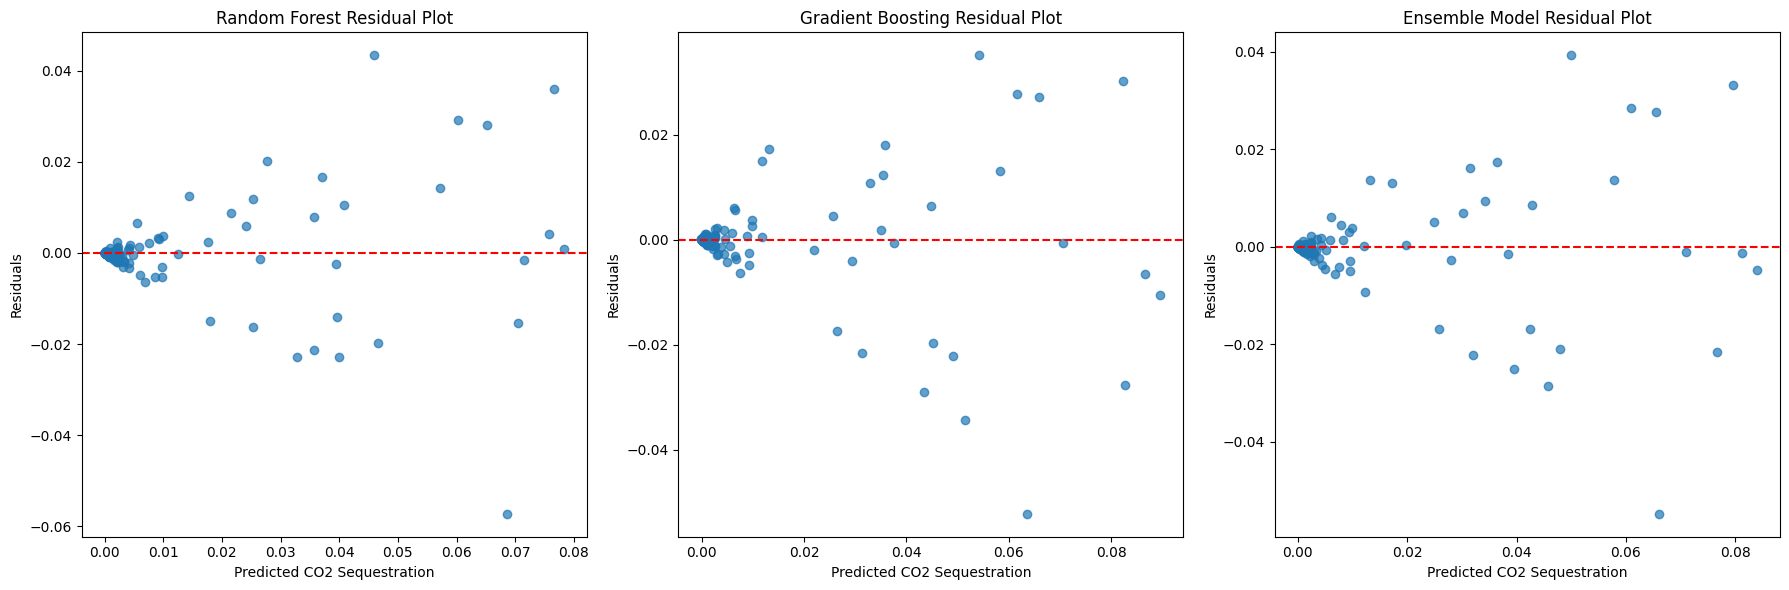

In [32]:
# Compare residuals from all models
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

rf_residuals = y_test - rf_y_pred
gbr_residuals = y_test - gbr_y_pred
ensemble_residuals = y_test - ensemble_y_pred

axs[0].scatter(rf_y_pred, rf_residuals, alpha=0.7)
axs[0].set_title('Random Forest Residual Plot')
axs[0].set_xlabel("Predicted CO2 Sequestration")
axs[0].set_ylabel("Residuals")
axs[0].axhline(0, color="red", linestyle="--")

axs[1].scatter(gbr_y_pred, gbr_residuals, alpha=0.7)
axs[1].set_title('Gradient Boosting Residual Plot')
axs[1].set_xlabel("Predicted CO2 Sequestration")
axs[1].set_ylabel("Residuals")
axs[1].axhline(0, color="red", linestyle="--")

axs[2].scatter(ensemble_y_pred, ensemble_residuals, alpha=0.7)
axs[2].set_title('Ensemble Model Residual Plot')
axs[2].set_xlabel("Predicted CO2 Sequestration")
axs[2].set_ylabel("Residuals")
axs[2].axhline(0, color="red", linestyle="--")
plt.tight_layout()
plt.show()


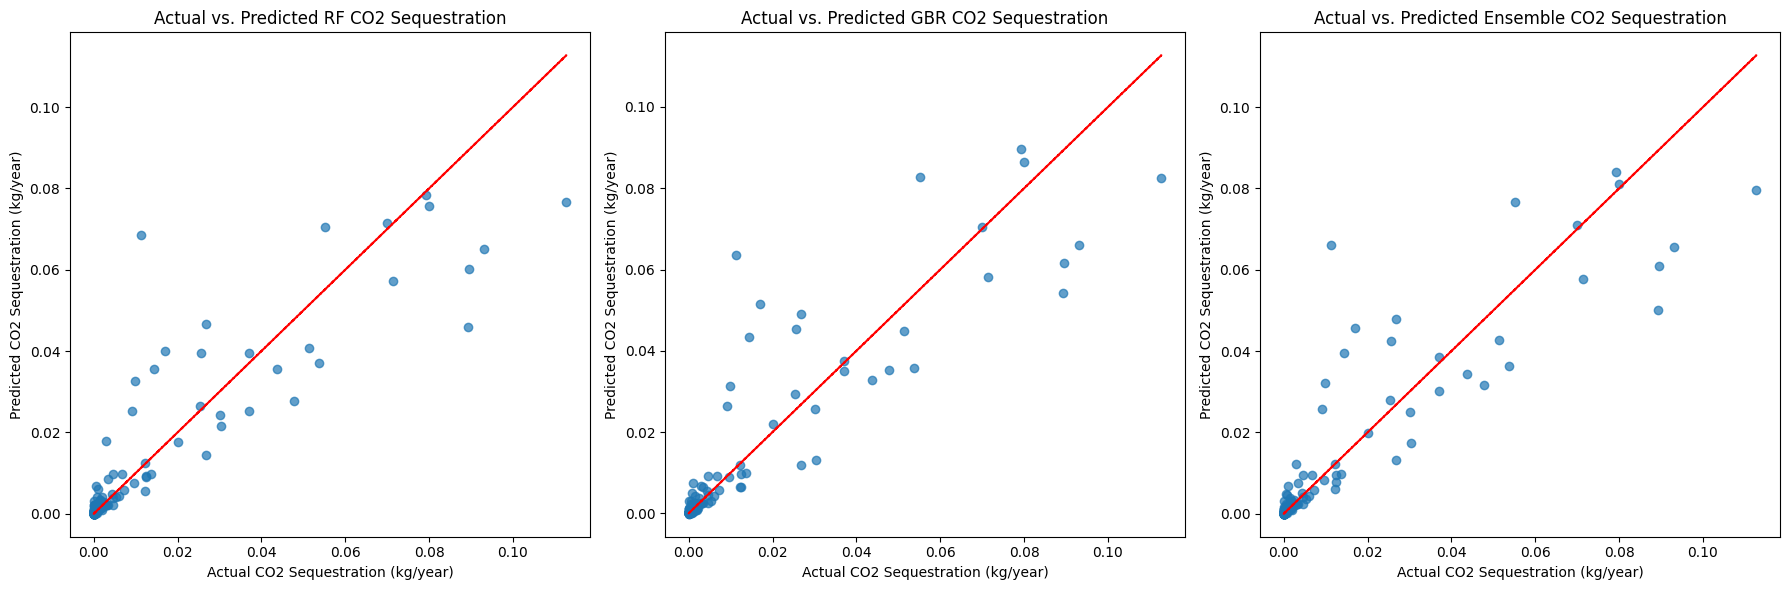

In [33]:
# Visualize prediction from all models
fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].scatter(y_test, rf_y_pred, alpha=0.7)
axs[0].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[0].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[0].set_title("Actual vs. Predicted RF CO2 Sequestration")
axs[0].plot(y_test,y_test, color="red", linestyle="--")

axs[1].scatter(y_test, gbr_y_pred, alpha=0.7)
axs[1].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[1].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[1].set_title("Actual vs. Predicted GBR CO2 Sequestration")
axs[1].plot(y_test,y_test, color="red", linestyle="--")

axs[2].scatter(y_test, ensemble_y_pred, alpha=0.7)
axs[2].set_xlabel("Actual CO2 Sequestration (kg/year)")
axs[2].set_ylabel("Predicted CO2 Sequestration (kg/year)")
axs[2].set_title("Actual vs. Predicted Ensemble CO2 Sequestration")
axs[2].plot(y_test,y_test, color="red", linestyle="--")

plt.tight_layout()
plt.show()